# What's this notebook about

I started tackling the mnist problem with the following ambitions: I was going to try the following sklearn classifiers on the mnist data set:

- KNeighborsClassifier
- SGDClassifier
- SVC with different kernels
- RandomForest
- ExtraTreesClassifier
- GradientBoost
- VotingClassifier

To reduce computing time or get better accuracy, I tried:

- cropping the images
- stratifying the images, meaning putting every pixel above a threshold 1 and all other zero
- polluting the images with some random pixels
- resize the images
- augmente the training images with shifted and rotated versions

I am a very beginner and working through the wonderfully written book "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques for Building Intelligent Systems" by Aurelien Geron. Somehow, I spent a lot effort working on mnist ending up not being better than vanilla sklearn classifiers such as RandomForestClassifier or KNearestNeighbor. In this notebook, I will sketch my older notebooks commenting what I think went wrong. In retrospective, this notebook became a little lengthy, so sorry if you get bored. Comments on my initial notebook are set in *italics*. Feel free to tell me more on the mistakes I made, best practice I violate or maybe nonsense you made in yourself in your first projects.

One of the first problems I encountered was the following:

## Failure: Don't use an old notebook

**Update**: *After uploading to Kaggle, I see that I have to run through all cells again, seeing that Kaggle works much faster than my notebook. If I had known this before... Note that in the comments or markup cells, the previous runtime of my notebook is often given and not the output of the actual cell you see*

**Update 2**: I found the reason why the SGDClassifier and the Nystroem-LinearSVC worked so poor on the augmented dataset. The transformation of the pictures with pixel range [0,255] gave pictures with pixel in range [0,1]. I corrected this mistake by dividing all train pixels by 255. So do not be surprised.

*Nothing is more annoying than having to wait for your notebook output or running into memory problems after a long notebook session. With mnist, I realized that my notebook (the system settings says Intel® Core™ i3-3217U CPU @ 1.80GHz × 4) was way too slow to use a standard gridsearch on KNearestNeighbor or SVCs. In particular, you never get to know how long it will take.
Another issue was that later when augmenting the data set I sometimes ran into memory failures. At that point, even relatively simpe algorithms did not work any more, and I could not help but restart the kernel. Thats in particular annoying when running long notebooks. Either you wait for 30 minutes or so for the kernel to be at the point where it breaked, or you have to search the cells to run which were needed at the point your are.*

*Therefore, my approach was how to go ahead with manipulating the pictures to compute faster or get better accuracy. Because of the time and memory issue, I just collected every import in the first cell, function in the second and class in the third cell to avoid searching the module I imported a function from. As you can see, I experimented a lot, but feel free to skip the functions or class. They will appear again when they are needed*

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import random
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# import sklearn functions
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,LabelEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC

# other stuff needed
from skimage.transform import resize
from scipy.stats import uniform, expon, randint
from scipy.ndimage.interpolation import shift, rotate

In [2]:
# the next two functions are taken from Aurelien Gerons book "Hands-On Machine Learning 
# with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques for Building Intelligent Systems",
# from the notebook https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb
def plot_digit(data, cmap='gray', size=28):
    image = data.reshape(size, size)
    plt.imshow(image, cmap = cmap,interpolation="nearest")
    #plt.axis("off")

def plot_digits(instances, images_per_row=10, size=28,**options):
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'gray', **options) # cmap = mpl.cm.binary
    plt.axis("off")

def fit_time_est(estimator, X_train, y_train, prnt=True):
    start = time.time()
    estimator.fit(X_train, y_train)
    end = time.time()
    if prnt:
        print("Time needed to fit the estimator:", end - start)
    return end - start

def fit_score_time(estimator, X_train, y_train, X_val, y_val, prnt=True, oob=False):
    time_fit = fit_time_est(estimator, X_train, y_train, prnt=False)
    if oob:
        if prnt:
            print("Time needed for fitting:", time_fit)
            print("Estimate of generalization error from oob (out of bag samples):", estimator.oob_score_)
        #return est, time_fit, est.oob_score_
    else:    
        start = time.time()
        y_pred = estimator.predict(X_val)
        acc_score = accuracy_score(y_pred,y_val)
        end = time.time()
        if prnt:
            print("Time needed for fitting:", time_fit)
            print("Valuation score:", acc_score, " with", end - start, "seconds needed to evaluate.")
    
def crop_inst(X_inst, tr_im_size=[28,28], crop_left=3, crop_right=3, crop_top=3, crop_bottom=3):
    """crop_data a data instance into its image_size, crops the given pixels from the border
    and transforms the new image back into a row array"""
    X_im = X_inst.reshape(tr_im_size)
    X_im = X_im[crop_top:-crop_bottom, crop_left:-crop_right] # do the cropping
    return X_im.reshape((tr_im_size[0]-crop_top-crop_bottom)*(tr_im_size[1]-crop_left-crop_right))
    

def crop_data(X_train, tr_im_size=[28,28], crop_left=3, crop_right=3, crop_top=3, crop_bottom=3):
    """crop_data turns every data instance into its image_size, crops the given pixels from the border
    and transforms the new image back into a row array, returning thus a new data set"""
    return np.apply_along_axis(crop_inst,1,X_train,tr_im_size=tr_im_size,crop_left=crop_left,
                               crop_right=crop_right, crop_top=crop_top, crop_bottom=crop_bottom)

def instance_resizer(instance, orig_im_size=(28,28), new_im_size=(14,14), mode='reflect', anti_aliasing=True):
    """takes a vector, interprets it as a picture, resizes it and returns the new image as a vector"""
    image_orig = instance.reshape(orig_im_size)
    image_new = resize(image_orig, new_im_size, mode=mode)
    inst_transformed = image_new.reshape(new_im_size[0]*new_im_size[1])
    return inst_transformed

def resize_train(X_train, orig_im_size=(28,28), new_im_size=(14,14), mode='reflect',anti_aliasing=True):
    """applies instance_resizer to every instance"""
    return np.apply_along_axis(instance_resizer,1,X_train,orig_im_size=orig_im_size,new_im_size=new_im_size,
                               mode=mode, anti_aliasing=anti_aliasing)

def stratify_data(X_train, threshold=230):
    return np.where(X_train>threshold/255, 1, 0).astype(np.bool) # the /255 comes from a former version where the pixels where not normalized

def pollute_instance(instance, im_size=(28,28), n_poll_pic=1, random_state = None):
    if not random_state is None:
        np.random.seed(random_state)
    inst = instance.copy() # otherwise, we change the original data
    image = inst.reshape(im_size)
    # set rectangle with pollution
    for _ in range(n_poll_pic):
        a, b = np.random.randint(0,im_size[0]), 1+int(4*np.random.uniform())
        c, d = np.random.randint(0,im_size[1]), 1+int(4*np.random.uniform())
        # start polluting
        for i in range(a,a+b):
            for j in range(c,c+d):
                try:
                    image[i,j] = np.random.randint(50,200)/255 # /255 is added because pixels are assumed to be in [0,1]
                except IndexError:
                    pass
    inst_transformed = image.reshape(im_size[0]*im_size[1])

    return inst_transformed
    

def pollute_training(X_train, im_size=(28,28), n_poll_pic=1, random_state = None):
    # usually, we would have used the following code, but it does not work with random_state set because in each
    # instance the same pixels are polluted
    if random_state is None:
        return np.apply_along_axis(pollute_instance,1,X_train,im_size=im_size,
                                   n_poll_pic=n_poll_pic, random_state=random_state)
    else:
        X_pol = X_train.copy()
        for i in range(X_train.shape[0]):
            X_pol[i] = pollute_instance(X_train[i],im_size=im_size, n_poll_pic=n_poll_pic,
                                        random_state=random_state+i)
        return X_pol

# shift_instance and rand_shift_training are adapted versions from Aurelien Gerons book chapter 3 additional material
# see his notebooks
# to avoid combinatorial explosion, we use random shifting and rotating

def shift_instance(instance, dx, dy, new=0, im_size=(28,28)):
    return shift(instance.reshape(im_size), [dy, dx], cval=new).reshape(im_size[0]*im_size[1])

def rand_shift_training(X_train, y_train, dx_max=2, dy_max=2, n_shifts = 4, new=0,
                        im_size=(28,28), random_state=None, only_axes=True, do_shuffle=True):
    
    if not random_state is None:
        np.random.seed(random_state)
    
    # collect all possibilities to move an image with given dx_max, dy_max
    moving_vectors = []
    if only_axes:
        for i in range(1,dx_max+1): # if i=0 or j=0, we will get double entries. we will remove them below
            moving_vectors.append((i,0))
            moving_vectors.append((-i,0))
        for i in range(1,dy_max+1):
            moving_vectors.append((0,i))
            moving_vectors.append((0,-i))
    else:
        for i in range(0,dx_max+1):
            for j in range(0,dy_max+1): # if i=0 or j=0, we will get double entries. we will remove them below
                moving_vectors.append((i,j))
                moving_vectors.append((-i,j))
                moving_vectors.append((i,-j))
                moving_vectors.append((-i,-j))
    
    moving_vectors = list(set(moving_vectors)) # removes double entries from moving_vectors

    # we do not want to double images, so remove (0,0) from moving_vectors
    try:
        moving_vectors.remove((0,0))
    except ValueError:
        if not only_axes: # because there should be no (0,0) inside if only_axes is True
            print("No (0,0) could be removed from moving_vectors. Please check the code.")
    
    
    X_train_expanded = []
    y_train_expanded = []
    
    # move image by moving_vectors and add to X_train_expanded
    for i in range(X_train.shape[0]):
        try:
            for dx, dy in random.sample(moving_vectors, n_shifts):
                shifted_image = shift_instance(X_train[i], dx=dx, dy=dy, new=0, im_size=im_size)
                X_train_expanded.append(shifted_image)
                y_train_expanded.append(y_train[i])
        except ValueError:
            print("Using maximal possible shifts. This might be smaller thatn n_shifts.")
            for dx, dy in moving_vectors:
                shifted_image = shift_instance(X_train[i], dx=dx, dy=dy, new=0, im_size=im_size)
                X_train_expanded.append(shifted_image)
                y_train_expanded.append(y_train[i])

    X_train_expanded = np.array(X_train_expanded, dtype=np.uint8)
    y_train_expanded = np.array(y_train_expanded, dtype=np.uint8)
    
    # shuffle the new shifted images to avoid classifiers see the same number for too many times
    if do_shuffle:
        X_train_expanded, y_train_expanded = shuffle(X_train_expanded, y_train_expanded, random_state=random_state)
    return X_train_expanded, y_train_expanded

def rand_rotate_instance(instance, angle=10, new=0, im_size=(28,28)):
    return rotate(instance.reshape(im_size), angle=angle, cval=new, reshape=False).reshape(im_size[0]*im_size[1])

def rand_rotate_training(X_train, y_train, angle_range=(5,10), im_size=(28,28),
                        sign=True, do_shuffle=True, random_state=None):
    
    if not random_state is None:
        np.random.seed(random_state)
    
    X_rot = X_train.copy()
    for i in range(X_train.shape[0]): # we need this loop to not always get the same rotation
        angle = np.random.randint(angle_range[0],angle_range[1])
        X_rot[i] = rand_rotate_instance(X_train[i],angle=angle,im_size=im_size)
    
    if sign:
        X_rot_sign = X_train.copy()
        for i in range(X_train.shape[0]): # we need this loop to not always get the same rotation
            angle = np.random.randint(angle_range[0],angle_range[1])
            X_rot_sign[i] = rand_rotate_instance(X_train[i],angle=-angle,im_size=im_size)
        
        # shuffle the new shifted images to avoid classifiers see the same number for too many times
        if do_shuffle:
            X_train_expanded, y_train_expanded = shuffle(np.concatenate((X_rot, X_rot_sign)),
                                                         np.concatenate((y_train, y_train)),
                                                         random_state=random_state)
        return X_train_expanded, y_train_expanded    
    else:
        return X_rot, y_train
    
def augment_training(X_train, y_train,dx_max=2,dy_max=2,n_shifts = 4,angle_range=(5,10),im_size=(28,28),
                     only_axes=False, do_shuffle=True, sign=True, random_state=None):
    X_shift, y_shift = rand_shift_training(X_train, y_train, dx_max=dx_max, dy_max=dy_max, n_shifts = n_shifts, 
                        im_size=im_size, random_state=random_state, only_axes=only_axes, do_shuffle=do_shuffle)
    X_rot, y_rot = rand_rotate_training(X_train, y_train, angle_range=angle_range, im_size=im_size,
                        sign=sign, do_shuffle=do_shuffle, random_state=random_state)
    X_train = np.concatenate((X_train,X_shift, X_rot))
    y_train = np.concatenate((y_train, y_shift, y_rot))
    return X_train, y_train

In [3]:
class ImageTransformer(BaseEstimator, TransformerMixin): # the arguments say that the new class inherits from the others, namely get/setparams_and fit_transform
    def __init__(self, resize=True, pollute=True, crop=True, stratify=True, n_poll_pic=1, random_state=None): # pass only whether to apply some transformations and random state
        self.resize = resize
        self.crop = crop
        self.stratify = stratify
        self.pollute = pollute
        self.n_poll_pic = n_poll_pic
        self.random_state = random_state
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X): # the X should be an array accessible by dataframe.values. Important as pipeline only handles these guys
        if self.pollute:
            X = pollute_training(X,n_poll_pic = self.n_poll_pic, random_state=self.random_state)
        if self.resize:
            if X.shape[1] != 14*14: # only resize if pictures are not already resized to (14,14)
                X = resize_train(X)
        if self.crop:
            X = crop_data(X, tr_im_size=[14,14], crop_left=1, crop_right=1, crop_top=1, crop_bottom=1)
        if self.stratify:
            stratify_data(X, threshold=0)
        return X

*Having most of the important things I had done so far at the very beginning was practical as you always know where to scroll or which cells to run if restarting the notebook. But most notebooks I have seen do this on the fly, so I guess I am violating best practices here.*

*The following was the outset of a tutorial I had in mind (haha!). So maybe with regard to the many classifiers I wanted to use, I should record:*

## Failure : Don't make big plans as a beginner

In [4]:
# load the data
df_train = pd.read_csv("../input/digit-recognizer/train.csv", engine='c')
df_test = pd.read_csv("../input/digit-recognizer/test.csv", engine='c')

In [5]:
# inspect the data
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# check for completeness
# only labels in the range of 0..9 ???
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

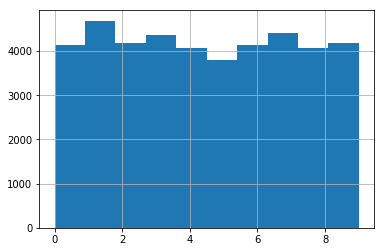

In [7]:
# so the labels appear more or less in the same frequence. in particular, accuracy score is fine
df_train['label'].hist()

In [8]:
# check for null values
df_train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [9]:
# no null value. great. lets start by taking the numpy arrays and splitting the label from the instances
y = df_train['label'].to_numpy(dtype = np.uint8)
X = df_train.drop(labels = ["label"],axis = 1).to_numpy()/255

In [10]:
# lets check sizes
print(y.shape)
print(X.shape)

(42000,)
(42000, 784)


## Splitting the data
We split our data up into the following parts:

- 32000 instances of: X_red_train for training models
- 5000 instances of : X_val for evaluating our estimators when we do not use cross-validation due to time consuming training
- 5000 instances of : X_test to look for the generalization error we are going to make, as by looking for parameters, we might overfit the validation data and checking on test data might bring us back to earth

The final estimator will be trained on the full data set and then applied to the test data of kaggle

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=5000, random_state=43, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=5000, random_state=43, stratify=y_train)

We are working on a classification problem. The numbers 0,...,9 can be interpreted by the algorithm as being near, meaning that e.g 0 and 1 are more related than 0 and 9. For those algorithms capable of interpreting, we use sklearns LabelBinarizer. The OneHotEncoder is meant for use on the features.

In [12]:
lab_bin = LabelBinarizer()
y_train_label = lab_bin.fit_transform(y_train)
y_val_label = lab_bin.transform(y_val) # dont fit again, so that the correspondance of digit and list keeps the same

In [13]:
# lets have a look how it works:
print(y_train[:10])
y_train_label[:10]

[6 6 8 8 4 0 8 8 4 3]


array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

*This is the point where I always used "run all cells above" when I restarted a kernel, because it defined the training data. Until now, I don't feel of having made any mistakes, but you are welcome to point some out.*

*The next part was about looking at the data, where I present the main ideas of manipulating the pictures:*

## Inspecting the data

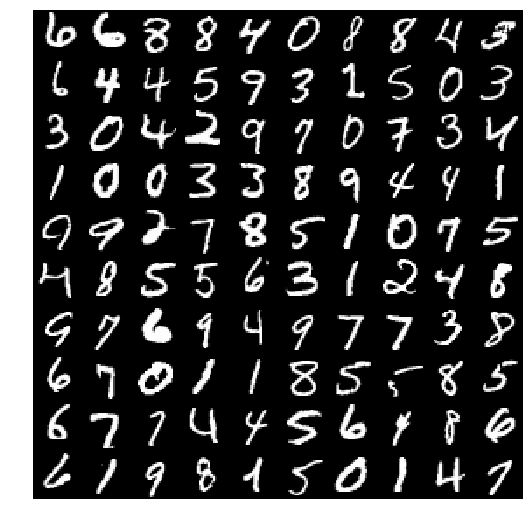

In [14]:
# lets see pictures
plt.figure(figsize=(9,9))
example_images = X_train[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

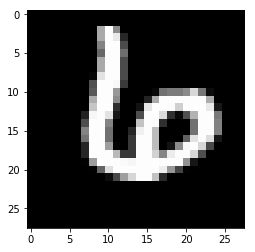

In [15]:
plot_digit(X_train[0])

It seems that we might crop some pictures to reduce dimensions, so from the left and right we could remove 3 pixels and from the top and bottom 3 pixels (actually, we could remove even more from the top most often). Note how the data seems to be cropped by default like the first six. Some ideas

- use the cropping as a feature, maybe centering the images horizontally and vertically. Note that centering makes us unable to use data augmentation by moving the image along axes, leaving only rotation
- remove outlier pixels as in the 6 shown in the middle of the hundred digits by removing pixels where the sum of neighbor pixels is low
- make the gray-scale binary by saying that everything above a threshold (say 230) is set to 255
- the drawing tends to be thick enough so that we can scale the pictures to 14x14 pictures without loosing to much information. the interpolation used is a hyperparameter

Furthermore, we will classically augment the training set by some shifts and rotations.

*I still think this sounds reasonable, but it turns out that the main good technique that worked was the resizing. The next section was considered to give a bar which is to raise: a simple Random Forest*

## A first shot: RandomForest

As a first attempt, we will just apply a vanilla RandomForest

In [16]:
# lets check the performance of a random forest as a bar
# they are rather fast, so we can apply the whole training set
rdf_clf = RandomForestClassifier(random_state=43, oob_score=True, n_jobs=-1) # n_jobs=-1 takes all processors

fit_score_time(rdf_clf, X_train, y_train, X_val, y_val, prnt=True, oob=True) # took 23 seconds, score 0.958

Time needed for fitting: 10.532341480255127
Estimate of generalization error from oob (out of bag samples): 0.95921875


Given that we did not anything special, this is a quick and good solution. At least we now know that the difficulty is to get a very good score. But wait: Shouldn't we apply categorical labeling? Lets give it a try:

In [17]:
fit_score_time(rdf_clf, X_train, y_train_label, X_val, y_val, prnt=True, oob=True) # took 45 seconds,score 0.986

Time needed for fitting: 19.390265703201294
Estimate of generalization error from oob (out of bag samples): 0.98665


*Note that for a long time I thought that using onehotencoding to the labels would increase the score. Later on I found out that the score on the validation set is much lower, so I thought of overfitting. But training with y_train makes out-of-bag score (oob_score) more or less equal to the score on the validation set. I still cannot explain this issue, so I would be very happy if you could shed some light on this issue.*

That's way better! But be warned that we did not restrict the depth of the trees and so on, and we will see that the oob score is much higher than on the validation set. And note that we only trained on 32000 instances. Another reason why RandomForests are often a great first shot is that they can tell you which feature they feel are important:

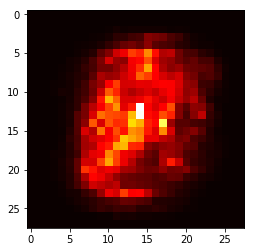

In [18]:
# as we can see, a great part of the picture is unimportant as we already saw
plot_digit(rdf_clf.feature_importances_, cmap=mpl.cm.hot)

*The things done so far were more or less okay, I think. In the following section, you see how I chose the wrong track: I made lots of calculations which are of no value: I trained several models on a way too small dataset. Note that I first tried the whole training set or big parts of it, which ended in interrupting (and sometimes crashing) the kernel. So be warned that you only see the tip of the iceberg here:*

## Looking how our proposed vanilla models work

We take a look at the models proposed at the beginning training them on small datasets

In [19]:
# WARNING: this code took about 150 seconds on my machine
knn = KNeighborsClassifier()
sgd = make_pipeline(StandardScaler(),SGDClassifier(random_state=43))
x_trees = ExtraTreesClassifier(random_state=43)
svc_rbf = make_pipeline(StandardScaler(),SVC(kernel='rbf', random_state=43)) #  kernel='rbf' is the default in sklearn
lin_svc = make_pipeline(StandardScaler(),LinearSVC(random_state=43))
grad_boost = GradientBoostingClassifier(random_state=43)

classifiers = [knn, sgd,x_trees,svc_rbf,lin_svc, grad_boost]

start = time.time()
for clf in classifiers:
    print(clf.__class__.__name__)
    for i in [100,300,900]:
        fit_score_time(clf, X_train[:i], y_train[:i], X_val, y_val, prnt=True, oob=False)
    print("**************************************************************")
end = time.time()
print("Total time needed:", end - start)

KNeighborsClassifier
Time needed for fitting: 0.0081787109375
Valuation score: 0.6524  with 0.9913444519042969 seconds needed to evaluate.
Time needed for fitting: 0.014332056045532227
Valuation score: 0.7784  with 2.687303066253662 seconds needed to evaluate.
Time needed for fitting: 0.046903371810913086
Valuation score: 0.863  with 6.974479913711548 seconds needed to evaluate.
**************************************************************
Pipeline
Time needed for fitting: 0.03537487983703613
Valuation score: 0.613  with 0.03112316131591797 seconds needed to evaluate.
Time needed for fitting: 0.09767556190490723
Valuation score: 0.754  with 0.03268861770629883 seconds needed to evaluate.
Time needed for fitting: 0.3385646343231201
Valuation score: 0.8514  with 0.029443979263305664 seconds needed to evaluate.
**************************************************************
ExtraTreesClassifier
Time needed for fitting: 0.23983383178710938
Valuation score: 0.73  with 0.10669541358947754 se

The GradientBoostingClassifier already took long on 1000 instances. Lets check the others additionally on 2700 instances.

In [20]:
# WARNING: This code took about 74 seconds on my machine
knn = KNeighborsClassifier()
sgd = make_pipeline(StandardScaler(),SGDClassifier(random_state=43)) # SGD needs all features to have a similar scale (which we have), so we do not try scaling yet
x_trees = ExtraTreesClassifier(random_state=43)
svc_rbf = make_pipeline(StandardScaler(),SVC(kernel='rbf', random_state=43)) # kernel='rbf' is the default
lin_svc = make_pipeline(StandardScaler(),LinearSVC(random_state=43))
grad_boost = GradientBoostingClassifier(random_state=43)

classifiers = [knn, sgd,x_trees,svc_rbf,lin_svc]

start = time.time()
for clf in classifiers:
    print(clf.__class__.__name__)
    for i in [2700]:
        fit_score_time(clf, X_train[:i], y_train[:i], X_val, y_val, prnt=True, oob=False)
    print("**************************************************************")
end = time.time()
print("Total time needed:", end - start)

KNeighborsClassifier
Time needed for fitting: 0.2049868106842041
Valuation score: 0.9164  with 23.58067488670349 seconds needed to evaluate.
**************************************************************
Pipeline
Time needed for fitting: 2.623548984527588
Valuation score: 0.8782  with 0.029937267303466797 seconds needed to evaluate.
**************************************************************
ExtraTreesClassifier
Time needed for fitting: 1.2328057289123535
Valuation score: 0.929  with 0.15026593208312988 seconds needed to evaluate.
**************************************************************
Pipeline
Time needed for fitting: 6.089871406555176
Valuation score: 0.9112  with 11.206018686294556 seconds needed to evaluate.
**************************************************************
Pipeline
Time needed for fitting: 15.224082469940186
Valuation score: 0.8048  with 0.029173612594604492 seconds needed to evaluate.
**************************************************************
Total time

/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


*So these were about 3.5 minutes computation, and more time to compare the times and scores manually. But I will not use them again, and they do not generalize well. I do not think that the 2700 instance training was sensible, and at a former version, I already started some hyperparameter training on training sizes of this range at this stage, which turned out useless and very time consuming. I wanted to see if I could get some good scores. So*

## Failure: Don't be impatient and greedy

*The function "fit_score_time" was written to print something nicely out, but already at this stage passing the times and scores to a DataFrame would be much more lucid. And it would not "spam" the notebook. Be aware that this will become more and more advisable later, but at the point I realized that I should have done it, I was too lazy to adjust the changes in all the code.*

## Failure:  Design your functions properly / don't sort data by hand

*Note that at this point I already knew that I did not want to include LinearSVC into a VotingClassifier, as there  would have been an SVC with kernel rbf or another solution (I found out that LinearSVC with Nystroem kernel approximation can be a good substitution, which I later included. Do not ask me why I still kept LinearSVC in the list below.*

So here are some observations:

Except for LinearSVC, all of the classifiers seem to work and become better. Lets focus on the training and validation time:

KNeighborsClassifier: needs very few time to fit no matter what the training size is, but tends to grow more than linear. the validation seems to grow linear with the number of training instances, so training on 32000 instances would take probably 416 seconds on my machine. That's no fun when doing cross validation.

ExtraTreesClassifier should behave like random forest, so there are no time issues here to discuss (at least on my machine). note that we should have applied the y_train_label to get better scores.

SGDClassifier: behaves in training and validation time like x_trees, so it should be no problem to apply it to the whole training data. note that it did not profit from training 900 or 2700 instances

lin_svc: seems to reach its top soon and will probably not make it into 95% and above, and it takes too much time

svc_rbf: seems to get much higher, but its training time grows more than linearly and - not to underestimate - its predicting time roughly grows linearly with the number of training instances: Training on 35000 instances will likely take 187 seconds predicting on the validation set on my machine, so too long for making much crossvalidation (apart from the fitting time that will raise non-linear)

grad_boost: Seems to work fine, but we have to look whether we could make it work in less time.

Next, just try manipulating our digit pictures!

*In the next chapter, I discuss the cropping of picture, which I show you as an example how all the next sections were build up.*

## Cropping images

In this section, we are going to cut the borders of the image and look for the performance of our classifiers

In [21]:
# the functions that will do the cropping
def crop_inst(X_inst, tr_im_size=[28,28], crop_left=3, crop_right=3, crop_top=3, crop_bottom=3):
    """crop_data a data instance into its image_size, crops the given pixels from the border
    and transforms the new image back into a row array"""
    X_im = X_inst.reshape(tr_im_size)
    X_im = X_im[crop_top:-crop_bottom, crop_left:-crop_right] # do the cropping
    return X_im.reshape((tr_im_size[0]-crop_top-crop_bottom)*(tr_im_size[1]-crop_left-crop_right))
    

def crop_data(X_train, tr_im_size=[28,28], crop_left=3, crop_right=3, crop_top=3, crop_bottom=3):
    """crop_data turns every data instance into its image_size, crops the given pixels from the border
    and transforms the new image back into a row array, returning thus a new data set"""
    return np.apply_along_axis(crop_inst,1,X_train,tr_im_size=tr_im_size,crop_left=crop_left,
                               crop_right=crop_right, crop_top=crop_top, crop_bottom=crop_bottom)

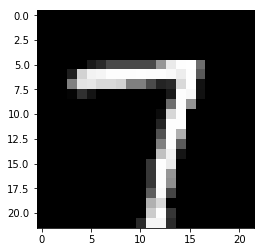

In [22]:
# crop_inst should work:
plot_digit(crop_inst(X_train[43]), size=22)

Time needed to crop all instances: 0.4743962287902832


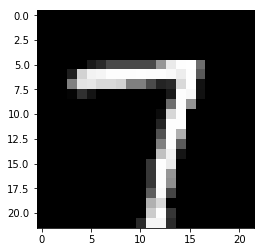

In [23]:
# crop_data should work and not take too long
start = time.time()
X_crp = crop_data(X_train)
end = time.time()
print("Time needed to crop all instances:", end-start)
plot_digit(X_crp[43], size=22)

In [24]:
# lets see how a random forest performs on the cropped set
rdf_clf = RandomForestClassifier(random_state=43, oob_score=True, n_jobs=-1)

fit_score_time(rdf_clf, X_crp, y_train_label, crop_data(X_val), y_val_label, prnt=True, oob=True) # took 50 seconds, score 0.987

Time needed for fitting: 22.602686405181885
Estimate of generalization error from oob (out of bag samples): 0.9868


Hey, thats 0.9867 vs 0.9864. But we wanted to reduce the time, and both roughly took 50 seconds even if we dropped 300 pixels per image. I guess that the RandomForest was intelligent enough to see this. But now take a look at the other classifiers and how they perform:

In [25]:
start = time.time()
for clf in classifiers: # reminder: classifiers = [knn,sgd,x_trees,svc_rbf,lin_svc]
    print(clf.__class__.__name__)
    fit_score_time(clf, X_crp[:2700], y_train[:2700], crop_data(X_val), y_val, prnt=True, oob=False)
    print("**************************************************************")
    
end = time.time()
print("Total time needed:", end - start)

KNeighborsClassifier
Time needed for fitting: 0.15390968322753906
Valuation score: 0.9126  with 14.434398651123047 seconds needed to evaluate.
**************************************************************
Pipeline
Time needed for fitting: 2.0138068199157715
Valuation score: 0.8808  with 0.01917123794555664 seconds needed to evaluate.
**************************************************************
ExtraTreesClassifier
Time needed for fitting: 1.1054632663726807
Valuation score: 0.9316  with 0.15257048606872559 seconds needed to evaluate.
**************************************************************
Pipeline
Time needed for fitting: 3.843366861343384
Valuation score: 0.9252  with 6.791297674179077 seconds needed to evaluate.
**************************************************************
Pipeline
Time needed for fitting: 10.52090573310852
Valuation score: 0.8026  with 0.018145084381103516 seconds needed to evaluate.
**************************************************************
Total tim

/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


So here are the approximate times for 2700 training instances needed:

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|not cropped   |  36   |      2.2 |     2.5  |   22.5   | 11.2    |
|cropped       |  22.5 |      1.6 |     2.8  |   13.9   | 7.5     |

Although it is not an incredible boost in computing time, it is either not bad. Now the scores:

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|not cropped   | 0.916 |    0.842 |   0.933  |   0.904  | 0.805   |
|cropped       | 0.913 |    0.826 |   0.930  |   0.925  | 0.803   |

*See, I started manually writing tables with the results...*

While the svc_rbf performed better and the sgd worse, I would't pay too much attention on the score difference as we did not trained several times on different training data. Lets observe that we do not loose to much information. Note that cropping might be bad to reach a top score as the difficulty lies in classifying the odd pictures. But for performance, this might be enough. Lets test cropping on the whole dataset where the classifier is quick enough (although still taking 235 seconds on my machine):

*As I said, I was not patient enough to wait for results on all training instances. From above, it is clear that this will take some minutes.*

In [26]:
# takes 235 seconds on my machine
if False: # to prevent the kernel to compute again
    start = time.time()
    print("Training instances are not cropped:")
    for clf in [sgd,x_trees]:
        print(clf.__class__.__name__)
        fit_score_time(clf, X_train, y_train, X_val, y_val, prnt=True, oob=False)
        print("**************************************************************")

    print("Training instances are cropped:")
    for clf in [sgd,x_trees]:
        print(clf.__class__.__name__)
        fit_score_time(clf, X_crp, y_train, crop_data(X_val), y_val, prnt=True, oob=False)
        print("**************************************************************")
    end = time.time()
    print("Total time needed:", end - start)

Hey, at least those too perform slightly better. At least, it is unlikely that the scoring will get much too worse.

*The next sections are only introduced with their pictures and the markdown cells, as the code remains similar. Only the training on the full training set is reduced to SGDClassifier and ExtraTreesClassifier*

## Stratifying images

We just want pictures where all pixels are either 1 or 0. Lets see how it performs:

In [27]:
# the function is really easy and should be very fast
def stratify_data(X_train, threshold=230):
    return np.where(X_train>threshold/255, 1, 0).astype(np.bool)

In [28]:
# Okay, lets apply
X_strat = stratify_data(X_train)

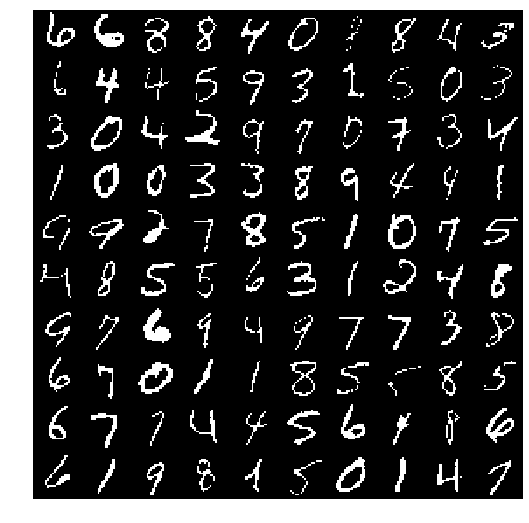

In [29]:
# no error yet, so lets look if it works:
plt.figure(figsize=(9,9))
plot_digits(X_strat[:100], images_per_row=10, size=28)

*I ended up seeing that the threshold 230 was too high, and tested it with 130 (so that's meant when stratified is said). In fact, setting the threshold to 0 (that means every pixel with value bigger than zero is set to 1) yielded better results. Here are some pictures:*

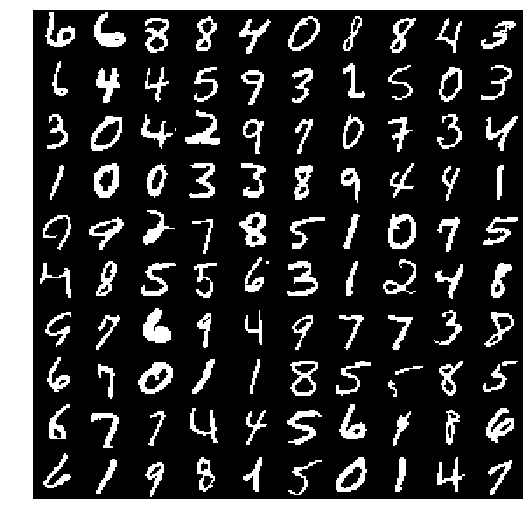

In [30]:
# threshold set to 130
plt.figure(figsize=(9,9))
plot_digits(stratify_data(X_train, threshold=130)[:100], images_per_row=10, size=28)

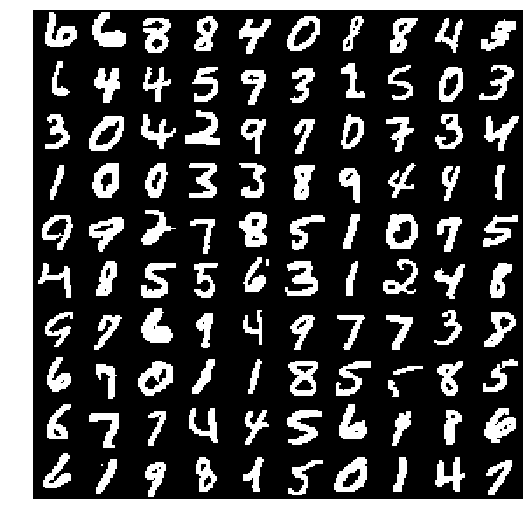

In [31]:
# threshold set to 0
plt.figure(figsize=(9,9))
plot_digits(stratify_data(X_train, threshold=0)[:100], images_per_row=10, size=28)

So we collect the data: Time needed (I assume that the stratifying is so quick that fitting the validation data does not count too much)

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    |  36   |      2.2 |     2.5  |   22.5   | 11.2    |
|cropped       |  22.5 |      1.6 |     2.8  |   13.9   | 7.5     |
|stratified    | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   |
|strat extreme | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   | times are roughly as stratified

And the scores:

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    | 0.916 |    0.842 |   0.933  |   0.904  | 0.805   |
|cropped       | 0.913 |    0.826 |   0.930  |   0.925  | 0.803   |
|stratified    | 0.895 |   0.831  | 0.921    |   0.901  |  0.766  |
|strat extreme | 0.922 |   0.853  | 0.941    |   0.917  |  0.794  |

For threshold=130, we have a loss in our scoring without being quicker. Thats surprising in particular for the xtrees, because the random forest was much quicker. But setting threshold=0, the scores become a little bit better for all classifiers. Lets try SGD and xtrees on all of the training set.

*After training SGD and xtrees, I gave stratify_data_soft a shot, meaning that each pixel value below threshold is turned to 0, the others remaining the same.*

In [32]:
def stratify_data_soft(X_train, threshold=130):
    return np.where(X_train>threshold/255, X_train, 0) # /255 added because data pixels are assumed to be in [0,1]

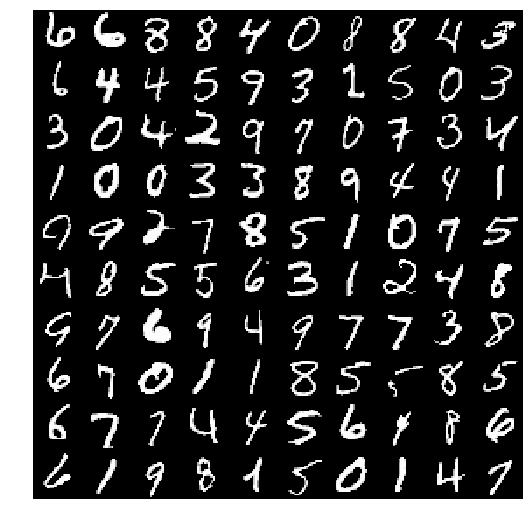

In [33]:
# stratify_data_soft with threshold=130:
plt.figure(figsize=(9,9))
plot_digits(stratify_data_soft(X_train, threshold=130)[:100], images_per_row=10, size=28)

So we collect the data: Time needed (I assume that the stratifying is so quick that fitting the validation data does not count too much)

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    |  36   |      2.2 |     2.5  |   22.5   | 11.2    |
|cropped       |  22.5 |      1.6 |     2.8  |   13.9   | 7.5     |
|stratified    | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   |
|strat extreme | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   | times are roughly as stratified
|soft strat    | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   | times are roughly as stratified

And the scores:

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    | 0.916 |    0.842 |   0.933  |   0.904  | 0.805   |
|cropped       | 0.913 |    0.826 |   0.930  |   0.925  | 0.803   |
|stratified    | 0.895 |   0.831  | 0.921    |   0.901  |  0.766  |
|strat extreme | 0.922 |   0.853  | 0.941    |   0.917  |  0.794  |
|strat soft    | 0.892 |   0.818  | 0.918    |   0.899  |  0.769  |

As expected, the scoring is worse when doin soft stratifying.

## Resizing the images

Here, we are going to rescale the images to reduce dimension and see how much information will be lost. First start playing around:

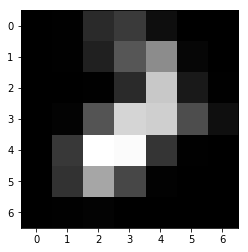

In [34]:
# reshape the data to 28x28 image
some_digit = X_train[42]
some_image = some_digit.reshape(28,28)

# resize the image to 7x7
from skimage.transform import resize
some_scaled_image = resize(some_image,(7,7))

plt.imshow(some_scaled_image, cmap = 'gray') # should be a 9

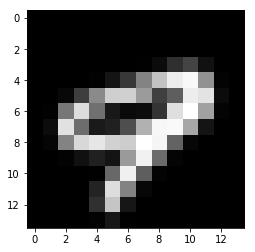

In [35]:
# Well, this will certainly be too small to train any digit recognizer (but maybe, you can try!)
# reshape the data to 28x28 image
some_digit = X_train[41]
some_image = some_digit.reshape(28,28)

# resize the image to 7x7
from skimage.transform import resize
some_scaled_image = resize(some_image,(14,14))

plt.imshow(some_scaled_image, cmap = 'gray') # should be a nine

In [36]:
# this seems reasonable or at least manageable. lets define the functions (note that the
# mode of the resizer and anti_aliasing are hyperparameter as well. we won't dive in this

def instance_resizer(instance, orig_im_size=(28,28), new_im_size=(14,14), mode='reflect', anti_aliasing=True):
    """takes a vector, interprets it as a picture, resizes it and returns the new image as a vector"""
    image_orig = instance.reshape(orig_im_size)
    image_new = resize(image_orig, new_im_size, mode=mode)
    inst_transformed = image_new.reshape(new_im_size[0]*new_im_size[1])
    return inst_transformed

def resize_train(X_train, orig_im_size=(28,28), new_im_size=(14,14), mode='reflect',anti_aliasing=True):
    """applies instance_resizer to every instance"""
    return np.apply_along_axis(instance_resizer,1,X_train,orig_im_size=orig_im_size,new_im_size=new_im_size,
                               mode=mode, anti_aliasing=anti_aliasing)

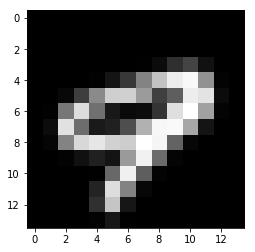

In [37]:
# apply on some digit
plt.imshow(instance_resizer(X_train[41]).reshape(14,14), cmap = 'gray')

Time needed for resizing: 38.47121739387512


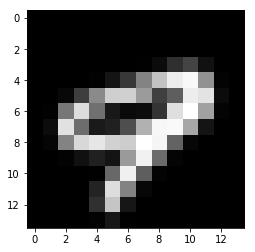

In [38]:
# looks fine. does it work on X_train? how long will it take?
start = time.time()
X_res = resize_train(X_train)
end = time.time()
print("Time needed for resizing:", end - start) # about 44 seconds
plt.imshow(X_res[41].reshape(14,14), cmap = 'gray')

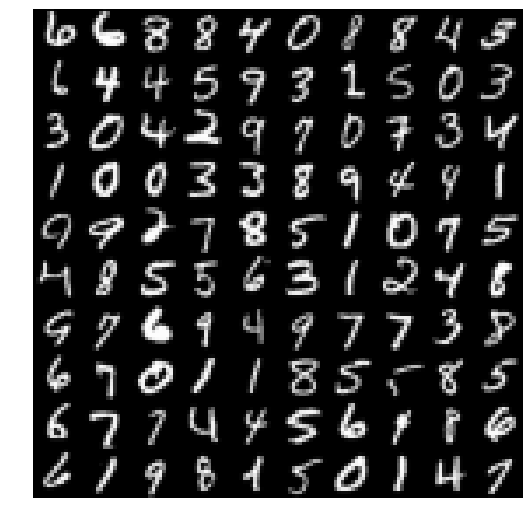

In [39]:
# looks nice. lets plot some of them:
plt.figure(figsize=(9,9))
plot_digits(X_res[:100], images_per_row=10, size=14)

So we add the stats (I should have altered the functions and use a pd DataFrame...)

Time needed

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    |  36   |      2.2 |     2.5  |   22.5   | 11.2    |
|cropped       |  22.5 |      1.6 |     2.8  |   13.9   | 7.5     |
|stratified    | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   |
|strat extreme | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   | times are roughly as stratified
|soft strat    | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   | times are roughly as stratified
|resize        | 9.7   |   0.61   | 1.4      |   5.8    |  3.2    |

And the scores:

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    | 0.916 |    0.842 |   0.933  |   0.904  | 0.805   |
|cropped       | 0.913 |    0.826 |   0.930  |   0.925  | 0.803   |
|stratified    | 0.895 |   0.831  | 0.921    |   0.901  |  0.766  |
|strat extreme | 0.922 |   0.853  | 0.941    |   0.917  |  0.794  |
|strat soft    | 0.892 |   0.818  | 0.918    |   0.899  |  0.769  |
|resize        | 0.930 |   0.882  | 0.937    |   0.921  |  0.859  |

So all in all, it not only gave us a time boost (okay, we killed 588 features from 784), but also increased the scoring. Lets check if this holds on the whole training set:

## Polluting the pictures

With stratifying, we have focused our digits on the essential forms. As the objective is to label the hard pictures right, we may want to force the classifiers to focus on the essential parts of a number by polluting the picture with some random pixels:

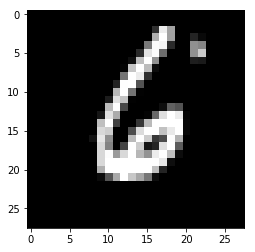

In [40]:
plot_digit(X_train[54])

In [41]:
# whats roughly the value for the pollution?
print(X_train[54].reshape(28,28)[5,22])
print(X_train[54].reshape(28,28)[4,22])

0.788235294117647
0.5215686274509804


In [42]:
# here are the functions:
def pollute_instance(instance, im_size=(28,28), n_poll_pic=1, random_state = None):
    if not random_state is None:
        np.random.seed(random_state)
    inst = instance.copy() # otherwise, we change the original data
    image = inst.reshape(im_size)
    # set rectangle with pollution
    for _ in range(n_poll_pic):
        a, b = np.random.randint(0,im_size[0]), 1+int(4*np.random.uniform())
        c, d = np.random.randint(0,im_size[1]), 1+int(4*np.random.uniform())
        # start polluting
        for i in range(a,a+b):
            for j in range(c,c+d):
                try:
                    image[i,j] = np.random.randint(50,200)/255 # /255 added afterwards because pixels now assumed to be in [0,1]
                except IndexError:
                    pass
    inst_transformed = image.reshape(im_size[0]*im_size[1])

    return inst_transformed
    

def pollute_training(X_train, im_size=(28,28), n_poll_pic=1, random_state = None):
    # usually, we would have used the following code, but it does not work with random_state set because in each
    # instance the same pixels are polluted
    if random_state is None:
        return np.apply_along_axis(pollute_instance,1,X_train,im_size=im_size,
                                   n_poll_pic=n_poll_pic, random_state=random_state)
    else:
        X_pol = X_train.copy()
        for i in range(X_train.shape[0]):
            X_pol[i] = pollute_instance(X_train[i],im_size=im_size, n_poll_pic=n_poll_pic,
                                        random_state=random_state+i)
        return X_pol

Time needed for polluting training data: 5.256902694702148


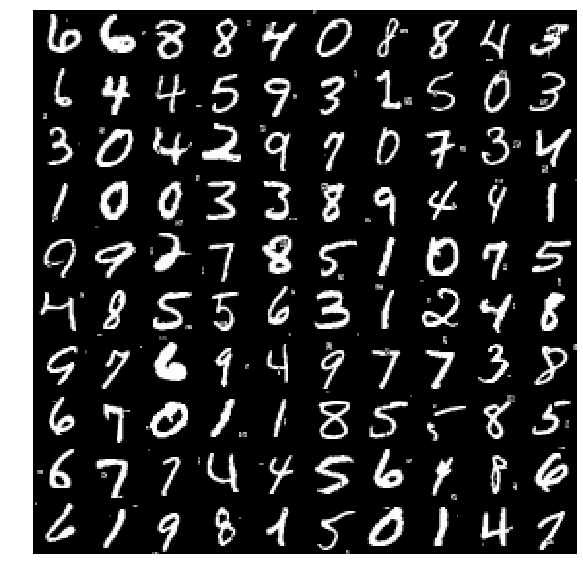

In [43]:
# lets try:
start = time.time()
X_pol = pollute_training(X_train, random_state=43)
end = time.time()
print("Time needed for polluting training data:", end - start) # is about 5 seconds, so quick enough
plt.figure(figsize=(10,10))
plot_digits(X_pol[:100], images_per_row=10, size=28)

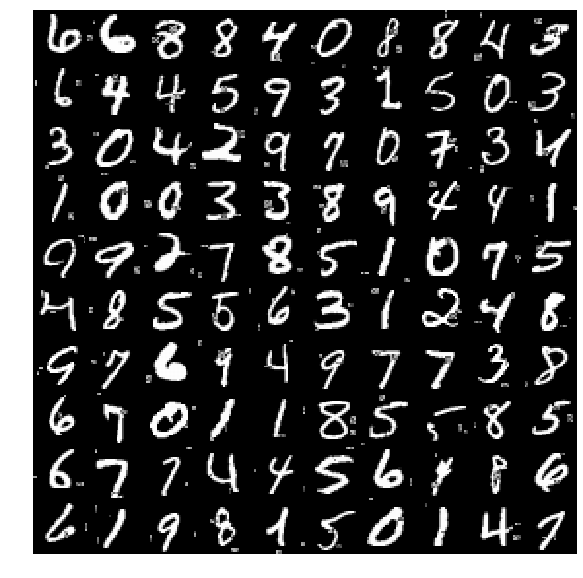

In [44]:
# nice. lets test two polluted areas:
plt.figure(figsize=(10,10))
plot_digits(pollute_training(X_train[:100], n_poll_pic=2), images_per_row=10, size=28)

As expected, the training time of the random forest did not change on the polluted data, whereas the score decreased slightly (0.004)

Add the stats

Time needed

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    |  36   |      2.2 |     2.5  |   22.5   | 11.2    |
|cropped       |  22.5 |      1.6 |     2.8  |   13.9   | 7.5     |
|stratified    | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   |
|strat extreme | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   | times are roughly as stratified
|soft strat    | 34.2  |   1.8    | 2.5      |   23.5   |  11.1   | times are roughly as stratified
|resize        | 9.7   |   0.61   | 1.4      |   5.8    |  3.2    |
|polluted      |  36   |      2.2 |     2.5  |   22.5   | 11.2    | times are roughly as unmodified

And the scores:

|training data |  knn  |     sgd  |  xtrees  | svc_rbf  | lin_svc |
|--------------|-------|----------|----------|----------|---------|
|unmodified    | 0.916 |    0.842 |   0.933  |   0.904  | 0.805   |
|cropped       | 0.913 |    0.826 |   0.930  |   0.925  | 0.803   |
|stratified    | 0.895 |   0.831  | 0.921    |   0.901  |  0.766  |
|strat extreme | 0.922 |   0.853  | 0.941    |   0.917  |  0.794  |
|strat soft    | 0.892 |   0.818  | 0.918    |   0.899  |  0.769  |
|resize        | 0.930 |   0.882  | 0.937    |   0.921  |  0.859  |
|polluted      | 0.914 |    0.856 |   0.933  |   0.922  | 0.821   |

So training took the same time on the polluted data, and accuracy did not become worse. In fact, the weaker learners svc's and sgd profited.

Lets test it on the whole resized dataset:

Not bad: The SGDClassifier jumped from 88.7 to 91.6, and x_trees kept ist score. Maybe, we will later play more with polluting (in particular number of polluted areas. Lets turn to:

## Data Augmentation

This is a standard technique and known to work well for MNIST. Although it will increase training time a lot, cropping and resizing might be so fast that my machine will not make too much trouble. *Haha, thats the point were I started to see memory failures*. Here we go:

In [45]:
# shift_instance and rand_shift_training are adapted versions from Aurelien Gerons book chapter 3 additional material
# see his notebooks
# to avoid combinatorial explosion, we use random shifting and rotating

def shift_instance(instance, dx, dy, new=0, im_size=(28,28)):
    return shift(instance.reshape(im_size), [dy, dx], cval=new).reshape(im_size[0]*im_size[1])

def rand_shift_training(X_train, y_train, dx_max=2, dy_max=2, n_shifts = 4, new=0,
                        im_size=(28,28), random_state=None, only_axes=True, do_shuffle=True):
    
    if not random_state is None:
        np.random.seed(random_state)
    
    # collect all possibilities to move an image with given dx_max, dy_max
    moving_vectors = []
    if only_axes:
        for i in range(1,dx_max+1): # if i=0 or j=0, we will get double entries. we will remove them below
            moving_vectors.append((i,0))
            moving_vectors.append((-i,0))
        for i in range(1,dy_max+1):
            moving_vectors.append((0,i))
            moving_vectors.append((0,-i))
    else:
        for i in range(0,dx_max+1):
            for j in range(0,dy_max+1): # if i=0 or j=0, we will get double entries. we will remove them below
                moving_vectors.append((i,j))
                moving_vectors.append((-i,j))
                moving_vectors.append((i,-j))
                moving_vectors.append((-i,-j))
    
    moving_vectors = list(set(moving_vectors)) # removes double entries from moving_vectors

    # we do not want to double images, so remove (0,0) from moving_vectors
    try:
        moving_vectors.remove((0,0))
    except ValueError:
        if not only_axes: # because there should be no (0,0) inside if only_axes is True
            print("No (0,0) could be removed from moving_vectors. Please check the code.")
    
    
    X_train_expanded = []
    y_train_expanded = []
    
    # move image by moving_vectors and add to X_train_expanded
    for i in range(X_train.shape[0]):
        try:
            for dx, dy in random.sample(moving_vectors, n_shifts):
                shifted_image = shift_instance(X_train[i], dx=dx, dy=dy, new=0, im_size=im_size)
                X_train_expanded.append(shifted_image)
                y_train_expanded.append(y_train[i])
        except ValueError:
            print("Using maximal possible shifts. This might be smaller thatn n_shifts.")
            for dx, dy in moving_vectors:
                shifted_image = shift_instance(X_train[i], dx=dx, dy=dy, new=0, im_size=im_size)
                X_train_expanded.append(shifted_image)
                y_train_expanded.append(y_train[i])

    X_train_expanded = np.array(X_train_expanded, dtype=np.uint8)
    y_train_expanded = np.array(y_train_expanded, dtype=np.uint8)
    
    # shuffle the new shifted images to avoid classifiers see the same number for too many times
    if do_shuffle:
        X_train_expanded, y_train_expanded = shuffle(X_train_expanded, y_train_expanded, random_state=random_state)
    return X_train_expanded, y_train_expanded

def rand_rotate_instance(instance, angle=10, new=0, im_size=(28,28)):
    return rotate(instance.reshape(im_size), angle=angle, cval=new, reshape=False).reshape(im_size[0]*im_size[1])

def rand_rotate_training(X_train, y_train, angle_range=(5,10), im_size=(28,28),
                        sign=True, do_shuffle=True, random_state=None):
    
    if not random_state is None:
        np.random.seed(random_state)
    
    X_rot = X_train.copy()
    for i in range(X_train.shape[0]): # we need this loop to not always get the same rotation
        angle = np.random.randint(angle_range[0],angle_range[1])
        X_rot[i] = rand_rotate_instance(X_train[i],angle=angle,im_size=im_size)
    
    if sign:
        X_rot_sign = X_train.copy()
        for i in range(X_train.shape[0]): # we need this loop to not always get the same rotation
            angle = np.random.randint(angle_range[0],angle_range[1])
            X_rot_sign[i] = rand_rotate_instance(X_train[i],angle=-angle,im_size=im_size)
        
        # shuffle the new shifted images to avoid classifiers see the same number for too many times
        if do_shuffle:
            X_train_expanded, y_train_expanded = shuffle(np.concatenate((X_rot, X_rot_sign)),
                                                         np.concatenate((y_train, y_train)),
                                                         random_state=random_state)
        return X_train_expanded, y_train_expanded    
    else:
        return X_rot, y_train

Normally, I would like to test the performance on the augmented set, but it would take too long time. *Because I tested this...*

Next, we are anyway writing a preprocessor class with some of our steps done so far.*That was my aim, but there are problems implementing data augmentation as one has to take care of passing a bigger target array. As far as I see this, sklearn classes are only meant to pass the training data in the transform method.*

## Fine tuning of our classifiers

First, we will transform our preprocessing steps into a custom transformer. Then we will do hyperparameter tuning on (hopefully) augmented, polluted, resized, cropped, stratified training data. Hopefully, the hyperparameters will be good enough when we will fit our models overnight on the augmented or augmented polluted training instances. So lets start with our custom transformer class:

In [46]:
class ImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, resize=True, pollute=True, crop=True, stratify=True, n_poll_pic=1, random_state=None): # pass only whether to apply some transformations and random state
        self.resize = resize
        self.crop = crop
        self.stratify = stratify
        self.pollute = pollute
        self.n_poll_pic = n_poll_pic
        self.random_state = random_state
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X): 
        if self.pollute:
            X = pollute_training(X,n_poll_pic = self.n_poll_pic, random_state=self.random_state)
        if self.resize:
            if X.shape[1] != 14*14: # only resize if pictures are not already resized to (14,14)
                X = resize_train(X)
        if self.crop:
            X = crop_data(X, tr_im_size=[14,14], crop_left=1, crop_right=1, crop_top=1, crop_bottom=1)
        if self.stratify:
            stratify_data(X, threshold=0)
        return X

In [47]:
def augment_training(X_train, y_train,dx_max=2,dy_max=2,n_shifts = 4,angle_range=(5,10),im_size=(28,28),
                     only_axes=False, do_shuffle=True, sign=True, random_state=None):
    X_shift, y_shift = rand_shift_training(X_train, y_train, dx_max=dx_max, dy_max=dy_max, n_shifts = n_shifts, 
                        im_size=im_size, random_state=random_state, only_axes=only_axes, do_shuffle=do_shuffle)
    X_rot, y_rot = rand_rotate_training(X_train, y_train, angle_range=angle_range, im_size=im_size,
                        sign=sign, do_shuffle=do_shuffle, random_state=random_state)
    X_train = np.concatenate((X_train,X_shift, X_rot))
    y_train = np.concatenate((y_train, y_shift, y_rot))
    return X_train, y_train

*The problem has already be explained: I would have liked to put augment_training into the class, but passing X and the target y into the transform method does not seem to fit the design of scikit-learn. Note that the class could be much more complete by passing the arguments of the functions when initializin, but I was too lazy to enable the class to do more than the default values of the functions.*

*What I did try first was to augment the training data with 4 shifts and two rotations of each instance, but running into memory problems. I restricted to 2 shifts, and polluted them, then resizing, then cropping and stratifying. But this took way too long because resizing the pictures takes time. So I was forced to first resize the pictures and then augment them (with maximal lenght of shifts 1).*

*Before augmenting the data, I wanted to look how polluting, cropping and stratifying affects the classifiers. This was way too greedy, as it took roughly 40 minutes:*

In [48]:
if False: # WARNING:took 2457 seconds on my machine
    knn = KNeighborsClassifier()
    sgd = make_pipeline(StandardScaler(),SGDClassifier(random_state=43)) # SGD needs all features to have a similar scale (which we have), so we do not try scaling yet
    x_trees = ExtraTreesClassifier(random_state=43)
    svc_rbf = make_pipeline(StandardScaler(),SVC(kernel='rbf', random_state=43)) #  kernel='rbf' is the default in sklearn
    svc_nyst_rbf = make_pipeline(StandardScaler(),Nystroem(kernel='rbf', random_state=43),LinearSVC())
    grad_boost = GradientBoostingClassifier(random_state=43)

    # now resize True for predicting
    im_transf = ImageTransformer(resize=True, pollute=True, crop=True, stratify=True,random_state=43)
    im_transf2 = ImageTransformer(resize=False, pollute=False, crop=True, stratify=True,random_state=43)

    classifiers = [knn, sgd, x_trees, svc_rbf, svc_nyst_rbf]
    params = [{'crop': [True,False], 'stratify': [True,False]}]

    X_val_res = resize_train(X_val) # so to not always resize again in the loop; we do not want pollute validating set

    start = time.time()
    for pol in [True, False]:
        im_transf.set_params(**{'resize': True, 'pollute': pol, 'crop': False, 'stratify': False,'random_state': 43})
        X = im_transf.transform(X_train)
        for dic in list(ParameterGrid(params)):
            im_transf2.set_params(**dic)
            print("Pollution is set to", pol)
            print("Now apply ImageTransformer with", im_transf2.get_params())
            for clf in classifiers: # reminder: classifiers = [knn,sgd,x_trees,svc_rbf,lin_svc]
                print(clf.__class__.__name__)
                fit_score_time(clf, im_transf2.transform(X), y_train, im_transf2.transform(X_val_res), y_val, prnt=True, oob=False)
                print("**************************************************************")

    end = time.time()
    print("Total time needed:", end - start)

*As you easily see, the output is a pain to evaluate.*

**Update** *Due to upload you don't see the inital output again, but its a long long list of the kind of cell 24, only longer and impractical to use*
## Failure: Care for a lucid overview of your results
*But if you do, you will see that the transformations applied nearly make no difference.*

*I next tried to pollute the pictures more, setting n_poll_pic = 10, which results in the following:*

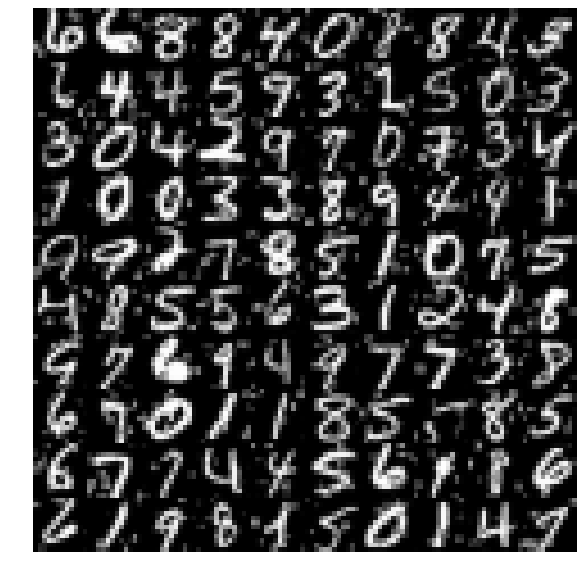

In [49]:
im_transf = ImageTransformer(resize=True, pollute=True, crop=True, stratify=False, n_poll_pic=10, random_state=43)
plt.figure(figsize=(10,10))
plot_digits(im_transf.transform(X_train[:100]), images_per_row=10, size=12)

*The classifiers responded worse on these pictures. So I decided to just use resizing, because it was the only technique that gave a real boost in computing time with nearly the same score.*

*Next, I started tuning the hyperparameters on the training set or on the first 10000 instances of the training set, hoping they would generalize well to the better training data. Like this:*

In [50]:
# thats the training data we work with
im_transf = ImageTransformer(resize=True, pollute=False, crop=False, stratify=False,random_state=43)
X = im_transf.transform(X_train)
X_val_res = im_transf.transform(X_val)

In [51]:
clf = KNeighborsClassifier(n_jobs=-1)
clf_params = [{'n_neighbors': [2,4,8], 'weights': ['uniform', 'distance']}]

for param in list(ParameterGrid(clf_params)): # reminder: classifiers = [knn,sgd,x_trees,svc_rbf,lin_svc]
    print(clf.__class__.__name__)
    clf.set_params(**param)
    print(param)
    fit_score_time(clf, X[:10000], y_train[:10000], X_val_res, y_val, prnt=True, oob=False)
    print("**************************************************************")

KNeighborsClassifier
{'n_neighbors': 2, 'weights': 'uniform'}
Time needed for fitting: 0.2797820568084717
Valuation score: 0.957  with 7.927957773208618 seconds needed to evaluate.
**************************************************************
KNeighborsClassifier
{'n_neighbors': 2, 'weights': 'distance'}
Time needed for fitting: 0.2792956829071045
Valuation score: 0.9566  with 8.024781703948975 seconds needed to evaluate.
**************************************************************
KNeighborsClassifier
{'n_neighbors': 4, 'weights': 'uniform'}
Time needed for fitting: 0.2813284397125244
Valuation score: 0.9616  with 8.43224811553955 seconds needed to evaluate.
**************************************************************
KNeighborsClassifier
{'n_neighbors': 4, 'weights': 'distance'}
Time needed for fitting: 0.2756998538970947
Valuation score: 0.9628  with 8.327327489852905 seconds needed to evaluate.
**************************************************************
KNeighborsClassifier

*Below is the moment I realized something strange was going on when using the LabelBinarizer on the targets with ExtraTreeClassifer or RandomForestClassifier: The oob_score differs much from the validation score:*

In [52]:
clf = ExtraTreesClassifier(random_state=43, n_jobs=-1, oob_score = True, bootstrap=True)
clf_params = [{'max_depth': [3,9,14], 'min_samples_split': [50, 100,500]}]

for param in list(ParameterGrid(clf_params)): # reminder: classifiers = [knn,sgd,x_trees,svc_rbf,lin_svc]
    print(clf.__class__.__name__)
    clf.set_params(**param)
    print(param)
    fit_score_time(clf, X, y_train_label, X_val_res, y_val_label, prnt=True, oob=False)
    print("oob score is:", clf.oob_score_)
    print("**************************************************************")

ExtraTreesClassifier
{'max_depth': 3, 'min_samples_split': 50}
Time needed for fitting: 4.395455360412598
Valuation score: 0.0154  with 0.41835522651672363 seconds needed to evaluate.
oob score is: 0.9016437500000001
**************************************************************
ExtraTreesClassifier
{'max_depth': 3, 'min_samples_split': 100}
Time needed for fitting: 4.210168361663818
Valuation score: 0.0154  with 0.4130995273590088 seconds needed to evaluate.
oob score is: 0.9016437500000001
**************************************************************
ExtraTreesClassifier
{'max_depth': 3, 'min_samples_split': 500}
Time needed for fitting: 4.314900636672974
Valuation score: 0.0156  with 0.41079139709472656 seconds needed to evaluate.
oob score is: 0.9016125
**************************************************************
ExtraTreesClassifier
{'max_depth': 9, 'min_samples_split': 50}
Time needed for fitting: 5.887819766998291
Valuation score: 0.5428  with 0.4117250442504883 seconds neede

In [53]:
# are the validation labels correct?
print(y_val[:20])
print(y_val_label[:20])

[4 0 8 7 9 0 7 6 3 9 8 7 1 5 8 7 3 9 1 2]
[[0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


*For some reason, working with the labels results in poor score on the validation set. I haven't rack my brain on this issue yet and welcome any explanation.*

*All in all, I ended with the configuration below:*

In [54]:
# so lets put them together into a voting team
svc_nyst = Pipeline([('std_scaler',StandardScaler()),
                ('nystroem',Nystroem(kernel='rbf', gamma=0.0034, random_state=43)),
                ('lin_svc',LinearSVC(C=5, dual=False, random_state=43))])
svc_rbf = Pipeline([('std_scaler',StandardScaler()),('rbf',SVC(kernel='rbf', C=5, gamma=0.005, random_state=43))])
rnd_for = RandomForestClassifier(random_state=43, n_jobs=-1)
x_trees = ExtraTreesClassifier(random_state=43, n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
sgd = make_pipeline(StandardScaler(),SGDClassifier(alpha= 0.0005, loss='hinge', penalty='l2', n_jobs=-1,
                                                        random_state=43))

vote_fast = VotingClassifier([('nystroem', svc_nyst), ('sgd',sgd)])
vote_slow = VotingClassifier([('rbf', svc_rbf), ('x_trees',x_trees), ('rnd_for',rnd_for), ('knn',knn)])

*I trained the fast classifiers on the augmented training set*

In [55]:
X_aug, y_aug = augment_training(resize_train(X_train),y_train,
                                dx_max=2,dy_max=2, n_shifts=4, im_size=(14,14),random_state=43)

In [56]:
start = time.time()
vote_fast.fit(X_aug,y_aug)
end = time.time()
print("Time fitting the fast voters:", end-start) # 132 seconds

Time fitting the fast voters: 205.75425362586975


*and the slow classifiers on the resized original training set*

In [57]:
start = time.time()
vote_slow.fit(X_res,y_train)
end = time.time()
print("Time fitting the slow voters:", end-start) # 150 seconds

Time fitting the slow voters: 89.37242031097412


*Here is the validation and test score for the slow voters*

In [58]:
X_test_res = resize_train(X_test)

In [59]:
print("Score on the validation set:",accuracy_score(y_val, vote_slow.predict(X_val_res)))
print("Score on the test set:",accuracy_score(y_test, vote_slow.predict(X_test_res)))

Score on the validation set: 0.9758
Score on the test set: 0.9774


In [60]:
for estimator in vote_slow.estimators_: # svc_rbf, extra_trees, random_forest, knn
    print("Score of", estimator.__class__.__name__, "on the validation set:", estimator.score(X_val_res, y_val))
    print("Score of", estimator.__class__.__name__, "on the test set:", estimator.score(X_test_res, y_test))

Score of Pipeline on the validation set: 0.972
Score of Pipeline on the test set: 0.9724
Score of ExtraTreesClassifier on the validation set: 0.9702
Score of ExtraTreesClassifier on the test set: 0.9682
Score of RandomForestClassifier on the validation set: 0.963
Score of RandomForestClassifier on the test set: 0.9626
Score of KNeighborsClassifier on the validation set: 0.9728
Score of KNeighborsClassifier on the test set: 0.9748


*And here for the fast classifiers:*

In [61]:
print("Score on the validation set:",accuracy_score(y_val, vote_fast.predict(X_val_res)))
print("Score on the test set:",accuracy_score(y_test, vote_fast.predict(X_test_res)))

Score on the validation set: 0.8614
Score on the test set: 0.8524


In [62]:
for estimator in vote_fast.estimators_: # nymstroem, sgd
    print("Score of", estimator.__class__.__name__, "on the validation set:", estimator.score(X_val_res, y_val))
    print("Score of", estimator.__class__.__name__, "on the test set:", estimator.score(X_test_res, y_test))

Score of Pipeline on the validation set: 0.8274
Score of Pipeline on the test set: 0.8236
Score of Pipeline on the validation set: 0.9136
Score of Pipeline on the test set: 0.9022


*That's the moment where I had to laugh. Funnily, the quick classifiers got much worse on the augmented dataset and I don't know why. In fact, I did some "quick" parameter search, but they tend to stay worse than the training on the original resized training set. Any idea?*

*Of course, one could go on analyzing the misclassified pictures or test other configurations, see how the slow classifiers behave on an augmented set and so on. But for me, this should suffice for a while working on mnist. Just predict the test data and hopefully see mnist again with neural networks.*

In [63]:
X_eval = df_test.to_numpy()
X_eval_res = resize_train(X_eval)

In [64]:
# this takes long because knn needs some time to predict 28000 instances
#y_eval = vote_slow.predict(X_eval_res) t

In [65]:
#df = pd.DataFrame(y_eval, columns=['Label'])
#df.index = np.arange(1, len(df)+1)
#df.to_csv(../output/submission.csv, index_label='ImageId') # scored 0.97342